In [27]:
# Note: This is a hack to allow importing from the parent directory
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent / "submodules/resnet-18-autoencoder/src"))

# Note: Ignore warnings, be brave (YoLo)
import warnings

warnings.filterwarnings("ignore")

In [28]:
import torch
import matplotlib.pyplot as plt

from utils import noop_collate
from models import ResNetAutoencoder
from data import CIFAR10GaussianSplatsDataset
from constants import CIFAR10_TRANSFORM, CIFAR10_INVERSE_TRANSFORM, TENSOR_TRANSFORM, PIL_TRANSFORM
from classes.resnet_autoencoder import AE as DefaultResNetAutoencoder

plt.style.use("../style/main.mpltstyle")

In [29]:
def collect_samples_by_label(data, n_samples, test_loader, class_to_index, index_to_class):
    data = {k: [] for k in class_to_index.keys()}
    all_labels_filled = False  

    for batch in test_loader:
        if all_labels_filled:
            break  

        for image, index, splat in batch:
            label = index_to_class[index]
            if len(data[label]) < n_samples:
                data[label].append((image, splat))

            all_labels_filled = all(len(v) >= n_samples for v in data.values())
            if all_labels_filled:
                break  
            
    return data


def default_forward(model, image):
    return PIL_TRANSFORM(model(TENSOR_TRANSFORM(image))[0])

In [30]:
N_SAMPLES = 1
CUSTOM_MODEL = None # TODO: ResNetAutoencoder()
DEFAULT_MODEL = DefaultResNetAutoencoder("light")
DEFAULT_MODEL.load_state_dict(torch.load("../models/default_resnet_autoencoder.ckpt")["model_state_dict"])

test_dataset = CIFAR10GaussianSplatsDataset(
    root="../data/CIFAR10GS",
    test=True,
    init_type="grid",
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=noop_collate,
)

CLASS_TO_INDEX = test_dataset.class_to_index
INDEX_TO_CLASS = {v: k for k, v in CLASS_TO_INDEX.items()}
DATA = collect_samples_by_label(test_dataset, N_SAMPLES, test_loader, CLASS_TO_INDEX, INDEX_TO_CLASS)
CUSTOM_RESULTS = {k: [] for k in CLASS_TO_INDEX.keys()}
DEFAULT_RESULTS = {k: [] for k in CLASS_TO_INDEX.keys()}

In [31]:
for label, samples in DATA.items():
    for image, splat in samples:
        if CUSTOM_MODEL:
            CUSTOM_RESULTS[label].append(CUSTOM_MODEL(image, splat)) # TODO: Implement
        if DEFAULT_MODEL:
            DEFAULT_RESULTS[label].append(default_forward(DEFAULT_MODEL, image))

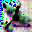

In [34]:
DEFAULT_RESULTS["airplane"][0]